# Student Assessments: Graph Analysis

## Dataset Description: Student Assessment Questionnaires

The dataset `assessment_generated.csv` contains information derived from student assessment questionnaires.

Each record represents an individual student's response and includes demographic, academic, and self-assessment information. The dataset comprises the following attributes:

- **`timestamp`**  
  The date and time when the assessment was submitted, formatted as `yyyy-mm-dd hh:mm:ss timezone`.

- **`netid`**  
  The encoded NetID of the student. Valid NetIDs must have a string length between 8 and 14 characters (inclusive). Entries falling outside this range are considered invalid.

- **`ruid`**  
  The encoded RUID of the student. A valid RUID is expected to contain exactly 18 characters. Any deviation from this length is considered invalid.

- **`section`**  
  The course section number as reported by the student. This field may contain inaccuracies, as some students provided incorrect section information.

- **`role`**  
  The academic standing of the student. Possible values include:
  - `Freshman`
  - `Sophomore`
  - `Junior`
  - `Senior`
  - `Graduate`
  - `Other`

- **`major`**  
  The declared major of the student. Accepted categories are:
  - `Computer Science`
  - `Electrical and Computer Engineering`
  - `Mathematics`
  - `Other`

- **Skill Proficiency Columns**  
  The following columns record students’ self-assessed proficiency levels in specific skills, rated on scales ranging from 0 up to a multiple of 5 (depending on the number of questions per topic). Missing values are present in some entries.

  - `data_structures`  
  - `calculus_and_linear_algebra`  
  - `probability_and_statistics`  
  - `data_visualization`  
  - `python_libraries`  
  - `shell_scripting`  
  - `sql`  
  - `python_scripting`  
  - `jupyter_notebook`  
  - `regression`  
  - `programming_languages`  
  - `algorithms`  
  - `complexity_measures`  
  - `visualization_tools`  
  - `massive_data_processing`


## Tasks

### Part I: Data Wrangling

*Note: This section follows a similar procedure to the previous bonus assignment.*

1.  **Handle Missing Values**
    *   Impute missing values in each skill proficiency column with the mean of that column.

2.  **Remove Duplicate Records**
    *   Eliminate duplicate entries, retaining only the record with the most recent `timestamp`.

3.  **Normalize Skill Proficiency**
    *   Apply both *z-score normalization* and *0-1 scaling* to each skill proficiency column. Retain both normalized versions for subsequent analysis.

4.  **Calculate Total Score**
    *   Generate a `total_score` column by summing the *z-score normalized* values across all skill proficiency topics for each student.

---

### Part II: Generating Graphs from Student Assessment Data

1.  **Data Inspection**
    *   Visualize the distribution of each skill proficiency topic using histograms for both 0-1 scaled scores and z-scores.

2.  **Define Distance Metric**
    *   Employ the *Euclidean distance* to quantify the similarity between students based on their normalized skill proficiency vectors.
      For students $A$ and $B$ with skill vectors $S_A$ and $S_B$:
      $$
      d(A, B) = \sqrt{\sum_{i=1}^{n} (S_{A,i} - S_{B,i})^2}
      $$
    *   Plot the distribution of all pairwise distances in a histogram.
    *   Apply *z-score normalization* to the computed pairwise distances.

3.  **Graph Construction Based on Distance Thresholds**
    *   Establish one or more thresholds at specified standard deviations (e.g., 3, 2, and 1) *below the mean distance*.
    *   For each threshold, construct an *undirected graph*. An edge is created between students $A$ and $B$ if their distance $d(A, B)$ is below the given threshold.
    *   Assign a name to each graph corresponding to the standard deviation used for its construction (e.g., `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, `Student_Assessment_Graph_-1SD`).
        *   What can be inferred about the graph connectivity as the threshold varies? Specifically, compare the number of edges in `Student_Assessment_Graph_-3SD`, `Student_Assessment_Graph_-2SD`, and `Student_Assessment_Graph_-1SD`.

4.  **Graph Analysis**
    *   For each constructed graph, compute and report the following metrics:
        *   Number of nodes and edges.
        *   Average degree.
        *   Degree distribution, visualized as a scatter plot with a vertical line indicating the average degree.
        *   Identify the top 10% of students by degree. List their `netid`s and `total_score`s.
            *   Highlight the data points for these top 10% of students on the scatter plot.
              *(Reference: [Matplotlib Annotations](https://matplotlib.org/stable/tutorials/text/annotations.html))*.
        *   Number of connected components.
        *   Plot the edge and vertex size distributions of connected components as scatter plots, with vertical lines indicating the average sizes.
    *   **Visualization**
        *   Render each graph using a *force-directed layout* (e.g., `spring_layout` in NetworkX).
          *(Reference: [NetworkX Spring Layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html))*.
        *   Color the nodes in the visualizations based on their `total_score` using a suitable colormap.
          *(Reference: [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html))*.
        *   Save each graph in JSON format and create interactive visualizations using:
            *   [2D Force Graph](https://github.com/vasturiano/force-graph)
            *   [3D Force Graph](https://github.com/vasturiano/3d-force-graph)

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import json
from itertools import chain, combinations
from collections import Counter
import matplotlib.colors as mcolors
COLORMAP = 'viridis'

# Define skill columns
skill_columns = [
    'data_structures', 'calculus_and_linear_algebra', 'probability_and_statistics',
    'data_visualization', 'python_libraries', 'shell_scripting', 'sql',
    'python_scripting', 'jupyter_notebook', 'regression', 'programming_languages',
    'algorithms', 'complexity_measures', 'visualization_tools', 'massive_data_processing'
]

In [68]:
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv('assessment_generated.csv')
    display(df.head())
    df.info()

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.0,5.0,0.0,5.0,12.0,22.0,20.0,4.0,14.0,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.0,5.0,1.0,NaN,0.0,15.0,9.0,4.0,1.0,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,NaN,5.0,0.0,0.0,4.0,15.0,NaN,NaN,9.0,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.0,5.0,5.0,1.0,NaN,27.0,32.0,10.0,NaN,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.0,5.0,1.0,1.0,12.0,13.0,7.0,0.0,6.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    157 non-null    object 
 1   netid                        157 non-null    object 
 2   ruid                         157 non-null    object 
 3   section                      157 non-null    int64  
 4   role                         157 non-null    object 
 5   major                        157 non-null    object 
 6   data_structures              148 non-null    float64
 7   calculus_and_linear_algebra  151 non-null    float64
 8   probability_and_statistics   152 non-null    float64
 9   data_visualization           151 non-null    float64
 10  python_libraries             147 non-null    float64
 11  shell_scripting              154 non-null    float64
 12  sql                          152 non-null    float64
 13  python_scripting    

# Part I: Data Wrangling

### 1. Handle Missing Values

In [69]:
def handle_missing_values(df, columns):
    """
    Fills missing values in specified columns with their respective column means.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to fill.
    
    OUT:
    df: pd.DataFrame, the dataframe with missing values filled.
    """
    df_filled = df
    for col in columns:
        mean_val = df_filled[col].mean()
        df_filled[col] = df_filled[col].fillna(mean_val)
    return df_filled

In [70]:
if __name__ == "__main__":
    df_filled = handle_missing_values(df.copy(), skill_columns)
    display(df_filled.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
0,2025-09-04 01:21:03 +0300,d2dbd3d0d5,786a2021217c6e2022,1,Junior,Computer Science,28.0,20.0,41.0,28.0,...,5.00000,5.0,0.0,5.000000,12.000000,22.0,20.000000,4.00000,14.00000,9.0
1,2025-09-04 00:28:39 +0200,c7dd9ac7c494,60703e393965793e3d,1,Junior,Computer Science,7.0,11.0,15.0,11.0,...,0.00000,5.0,1.0,2.369128,0.000000,15.0,9.000000,4.00000,1.00000,2.0
2,2025-09-03 18:22:47 -0400,5d504543461b,0f1d55565609195250,1,Senior,Mathematics,22.0,15.0,22.0,22.0,...,1.11039,5.0,0.0,0.000000,4.000000,15.0,12.879195,3.75817,9.00000,1.0
3,2025-09-04 06:29:53 +0800,021b4e0503,5145080b0b52450c0a,3,Senior,Computer Science,29.0,19.0,55.0,28.0,...,1.00000,5.0,5.0,1.000000,4.061644,27.0,32.000000,10.00000,3.90411,8.0
4,2025-09-03 16:31:34 -0600,8b8cc28089de,5d4c0104045b490005,1,Junior,Computer Science,25.0,14.0,43.0,23.0,...,1.00000,5.0,1.0,1.000000,12.000000,13.0,7.000000,0.00000,6.00000,0.0


### 2. Remove Duplicate Records

Drop duplicates based on `ruid`, retaining the record with the latest `timestamp`.

In [71]:
def remove_duplicates(df):
    """
    Removes duplicate entries based on 'ruid', keeping the one with the latest 'timestamp'.

    IN:
    df: pd.DataFrame, the input dataframe.
    
    OUT:
    df: pd.DataFrame, the dataframe with duplicates removed.
    """
    df_sorted = df
    df_sorted['timestamp'] = pd.to_datetime(df_sorted['timestamp'], errors='coerce', utc=True)
    df_dedup = (
        df_sorted
        .sort_values('timestamp')
        .drop_duplicates(subset='ruid', keep='last')
    )

    return df_dedup

In [72]:
if __name__ == "__main__":
    df_dedup = remove_duplicates(df_filled.copy())
    display(df_dedup.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,shell_scripting,sql,python_scripting,jupyter_notebook,regression,programming_languages,algorithms,complexity_measures,visualization_tools,massive_data_processing
90,2025-09-03 22:05:22+00:00,c1d4dedb,8591dadfdf8c9fded6,3,Senior,Computer Science,13.0,14.410596,14.0,35.0,...,1.0,0.0,0.0,0.0,3.0,19.0,30.0,2.0,7.0,2.0
31,2025-09-03 22:05:49+00:00,fce8fefdf5a0,33226d6a6a3425686a,1,Junior,Computer Science,4.0,13.000000,13.0,14.0,...,1.0,1.0,1.0,1.0,0.0,6.0,4.0,1.0,0.0,0.0
102,2025-09-03 22:06:05+00:00,8a90d1898fdf,acbef4f5f5acbcf2fd,3,Senior,Mathematics,20.0,24.000000,52.0,29.0,...,1.0,1.0,1.0,1.0,9.0,18.0,20.0,5.0,0.0,0.0
156,2025-09-03 22:06:40+00:00,d6da8cd2d28d,11024f48481a064940,3,Junior,Computer Science,9.0,6.000000,9.0,12.0,...,1.0,1.0,1.0,1.0,0.0,7.0,5.0,2.0,0.0,0.0
22,2025-09-03 22:06:41+00:00,d3ca9bdadc85,f5e7a8acacf3ecaeaa,3,Senior,Computer Science,29.0,16.000000,34.0,13.0,...,1.0,1.0,0.0,1.0,1.0,19.0,11.0,6.0,0.0,0.0


### 3. Normalize Skill Proficiency

The new columns for z-score normalization and 0-1 scaling should be named as follows:
- For a skill proficiency column named `skill_topic`, the z-score normalized column should be `skill_topic_zscore`.
- For a skill proficiency column named `skill_topic`, the 0-1 scaled column should be `skill_topic_01scale`.

In [73]:
def normalize_skills(df, columns):
    """
    Applies z-score normalization and 0-1 scaling to specified columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    columns: list of str, the columns to normalize.
    
    OUT:
    df: pd.DataFrame, the dataframe with added normalized columns.
    """
    df_normalized = df
    for col in columns:
        s = pd.to_numeric(df_normalized[col], errors='coerce')

        z = (s - s.mean()) / s.std(ddof=0)
        df_normalized[f"{col}_zscore"] = z

        min_v, max_v = s.min(), s.max()
        if pd.isna(min_v) or pd.isna(max_v) or max_v == min_v:
            scaled = s * 0.0
        else:
            scaled = (s - min_v) / (max_v - min_v)
        df_normalized[f"{col}_01scale"] = scaled
    
    return df_normalized

In [74]:
if __name__ == "__main__":
    df_normalized = normalize_skills(df_dedup.copy(), skill_columns)
    display(df_normalized.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,programming_languages_zscore,programming_languages_01scale,algorithms_zscore,algorithms_01scale,complexity_measures_zscore,complexity_measures_01scale,visualization_tools_zscore,visualization_tools_01scale,massive_data_processing_zscore,massive_data_processing_01scale
90,2025-09-03 22:05:22+00:00,c1d4dedb,8591dadfdf8c9fded6,3,Senior,Computer Science,13.0,14.410596,14.0,35.0,...,0.626305,0.678571,2.224854,0.857143,-0.606609,0.2,0.586747,0.304348,0.198546,0.166667
31,2025-09-03 22:05:49+00:00,fce8fefdf5a0,33226d6a6a3425686a,1,Junior,Computer Science,4.0,13.000000,13.0,14.0,...,-1.741821,0.214286,-1.249646,0.114286,-0.925729,0.1,-0.794358,0.000000,-0.631725,0.000000
102,2025-09-03 22:06:05+00:00,8a90d1898fdf,acbef4f5f5acbcf2fd,3,Senior,Mathematics,20.0,24.000000,52.0,29.0,...,0.444141,0.642857,0.888508,0.571429,0.350752,0.5,-0.794358,0.000000,-0.631725,0.000000
156,2025-09-03 22:06:40+00:00,d6da8cd2d28d,11024f48481a064940,3,Junior,Computer Science,9.0,6.000000,9.0,12.0,...,-1.559657,0.250000,-1.116012,0.142857,-0.606609,0.2,-0.794358,0.000000,-0.631725,0.000000
22,2025-09-03 22:06:41+00:00,d3ca9bdadc85,f5e7a8acacf3ecaeaa,3,Senior,Computer Science,29.0,16.000000,34.0,13.0,...,0.626305,0.678571,-0.314204,0.314286,0.669872,0.6,-0.794358,0.000000,-0.631725,0.000000


### 4. Calculate Total Score

In [75]:
def compute_total_score(df, zscore_columns):
    """
    Computes the total score as the sum of z-score normalized skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_columns: list of str, the z-score normalized columns to sum.
    
    OUT:
    df: pd.DataFrame, the dataframe with the 'total_score' column.
    """
    df_total = df.copy()
    df_total['total_score'] = df_total[zscore_columns].sum(axis=1, skipna=True)
    return df_total

In [76]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    final_df = compute_total_score(df_normalized, zscore_cols)
    display(final_df.head())

,timestamp,netid,ruid,section,role,major,data_structures,calculus_and_linear_algebra,probability_and_statistics,data_visualization,...,programming_languages_01scale,algorithms_zscore,algorithms_01scale,complexity_measures_zscore,complexity_measures_01scale,visualization_tools_zscore,visualization_tools_01scale,massive_data_processing_zscore,massive_data_processing_01scale,total_score
90,2025-09-03 22:05:22+00:00,c1d4dedb,8591dadfdf8c9fded6,3,Senior,Computer Science,13.0,14.410596,14.0,35.0,...,0.678571,2.224854,0.857143,-0.606609,0.2,0.586747,0.304348,0.198546,0.166667,0.861557
31,2025-09-03 22:05:49+00:00,fce8fefdf5a0,33226d6a6a3425686a,1,Junior,Computer Science,4.0,13.000000,13.0,14.0,...,0.214286,-1.249646,0.114286,-0.925729,0.1,-0.794358,0.000000,-0.631725,0.000000,-13.913913
102,2025-09-03 22:06:05+00:00,8a90d1898fdf,acbef4f5f5acbcf2fd,3,Senior,Mathematics,20.0,24.000000,52.0,29.0,...,0.642857,0.888508,0.571429,0.350752,0.5,-0.794358,0.000000,-0.631725,0.000000,2.451389
156,2025-09-03 22:06:40+00:00,d6da8cd2d28d,11024f48481a064940,3,Junior,Computer Science,9.0,6.000000,9.0,12.0,...,0.250000,-1.116012,0.142857,-0.606609,0.2,-0.794358,0.000000,-0.631725,0.000000,-15.052428
22,2025-09-03 22:06:41+00:00,d3ca9bdadc85,f5e7a8acacf3ecaeaa,3,Senior,Computer Science,29.0,16.000000,34.0,13.0,...,0.678571,-0.314204,0.314286,0.669872,0.6,-0.794358,0.000000,-0.631725,0.000000,-4.258010


# Part II: Generating Graphs from Student Assessment Data

### 1. Data Inspection

Note: Use the population standard deviation (`ddof=0`) for all standard deviation calculations.

In [77]:
def compute_mean_std(df, zscore_cols, scale01_cols):
    """
    Computes and prints the mean and standard deviation for z-score normalized
    and 0-1 scaled skill columns.
    
    IN:
    df: pd.DataFrame, the input dataframe.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.

    OUT:
    mean_std: dict of dicts {column_name: {'mean': mean_value, 'std': std_value}}, where mean_value and std_value are np.float64 types.
    """
    mean_std = {}

    for col in zscore_cols + scale01_cols:
        # compute the 2 values
        mean = np.float64(df[col].mean())
        std = np.float64(df[col].std())

        # update index of column in dictionary with its own dictionary
        mean_std[col] = {'mean': mean, 'std': std} 

    return mean_std

To indicate the mean and standard deviation on the histograms, you may use the following functions:
- `plt.axvline()` to draw vertical lines at the mean.
- `plt.annotate()` to label these lines with their corresponding values.

**References:**
- [`plt.axvline()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)
- [`plt.annotate()` Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

**Example Usage:**
```python
# Plot a vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--')

# Annotate the line with text
plt.annotate('Mean', xy=(0, 0), color='red')
```

In [78]:
def plot_skill_distributions(df, zscore_cols, scale01_cols, mean_std):
    """
    Plots histograms for z-score and 0-1 scaled skill proficiency columns.
    
    IN:
    df: pd.DataFrame, the dataframe containing the data.
    zscore_cols: list of str, the z-score normalized columns.
    scale01_cols: list of str, the 0-1 scaled columns.
    mean_std: dict of dicts, mean and std dev for each column.
    """

    # add lines for mean and std dev for each column
    def add_mean_std_lines(col):

        # get mean and std dev value from each column
        mean = mean_std[col]['mean']
        std = mean_std[col]['std']

        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    
        plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {std:.2f}')
        plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=2)

    # z score columns
    for col in zscore_cols:
        plt.figure()
        plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        add_mean_std_lines(col)
        plt.title(f'Histogram of {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
    
    # 0-1 scaled columns
    for col in scale01_cols:
        plt.figure()
        plt.hist(df[col], bins=20, color='orange', edgecolor='black')
        add_mean_std_lines(col)
        plt.title(f'Histogram of {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
    



data_structures_zscore: Mean = -0.0000, Std Dev = 1.0033
calculus_and_linear_algebra_zscore: Mean = 0.0000, Std Dev = 1.0033
probability_and_statistics_zscore: Mean = -0.0000, Std Dev = 1.0033
data_visualization_zscore: Mean = 0.0000, Std Dev = 1.0033
python_libraries_zscore: Mean = -0.0000, Std Dev = 1.0033
shell_scripting_zscore: Mean = -0.0000, Std Dev = 1.0033
sql_zscore: Mean = 0.0000, Std Dev = 1.0033
python_scripting_zscore: Mean = 0.0000, Std Dev = 1.0033
jupyter_notebook_zscore: Mean = 0.0000, Std Dev = 1.0033
regression_zscore: Mean = 0.0000, Std Dev = 1.0033
programming_languages_zscore: Mean = -0.0000, Std Dev = 1.0033
algorithms_zscore: Mean = -0.0000, Std Dev = 1.0033
complexity_measures_zscore: Mean = -0.0000, Std Dev = 1.0033
visualization_tools_zscore: Mean = -0.0000, Std Dev = 1.0033
massive_data_processing_zscore: Mean = 0.0000, Std Dev = 1.0033
data_structures_01scale: Mean = 0.6040, Std Dev = 0.2152
calculus_and_linear_algebra_01scale: Mean = 0.5783, Std Dev = 0.20

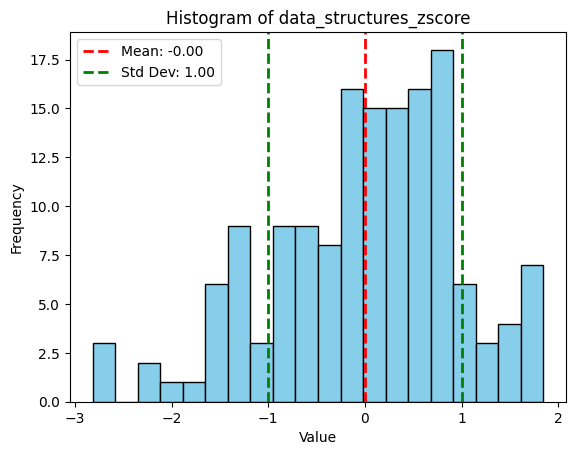

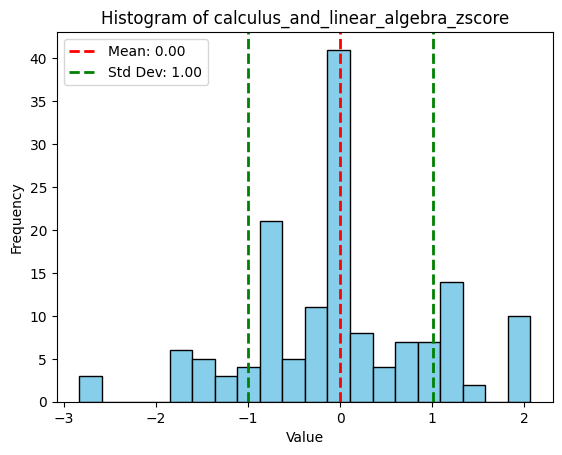

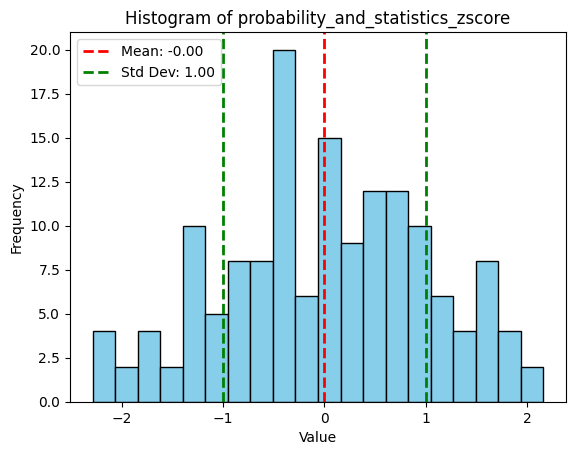

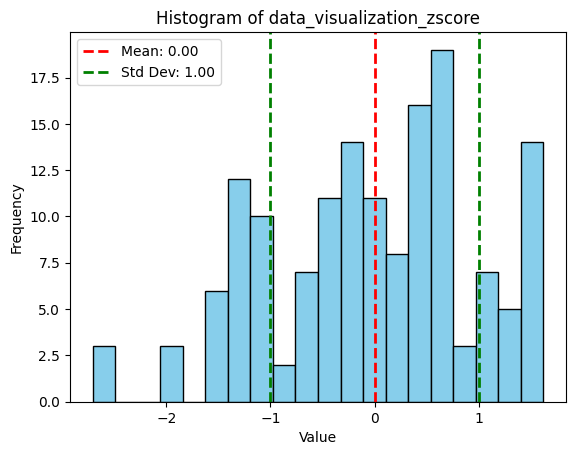

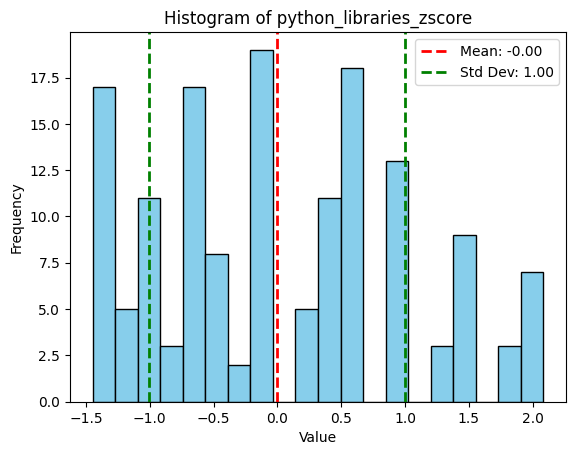

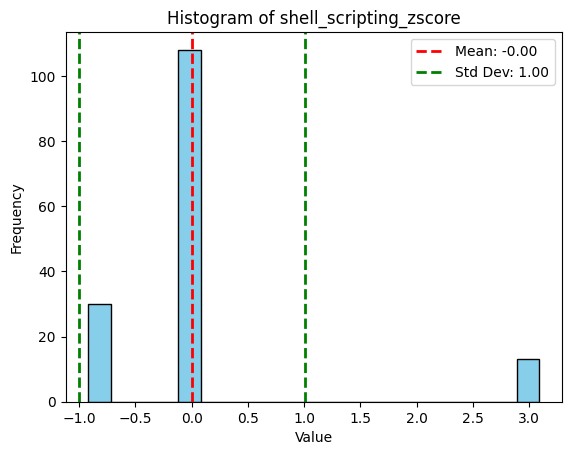

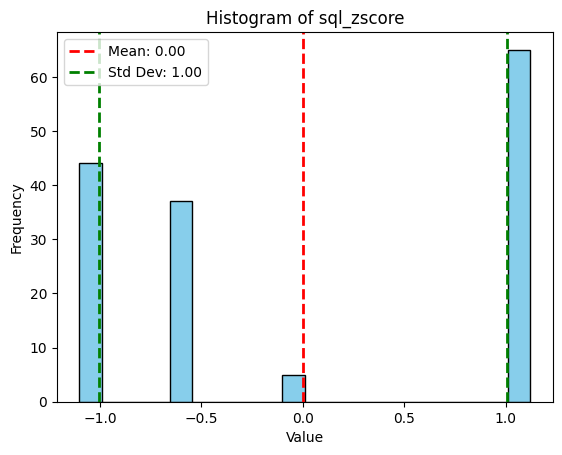

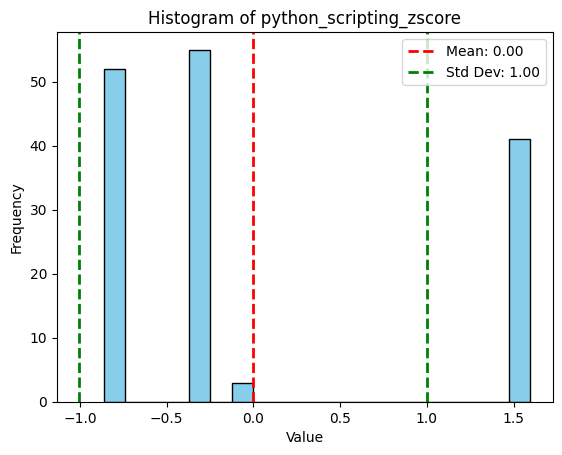

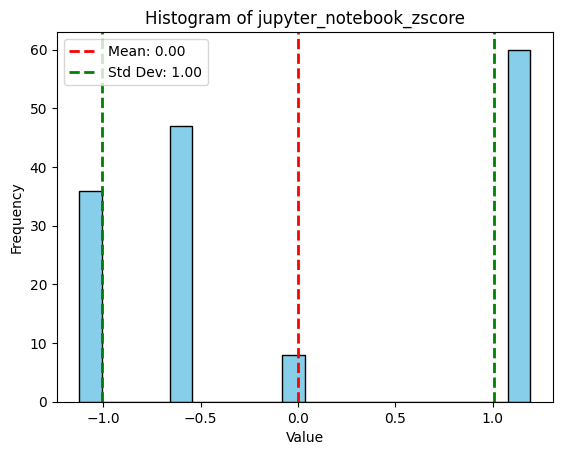

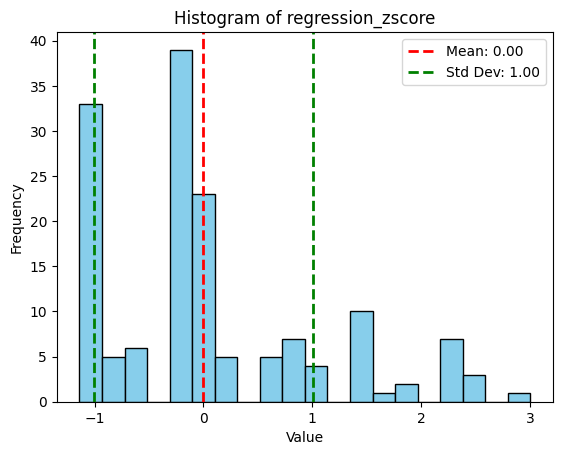

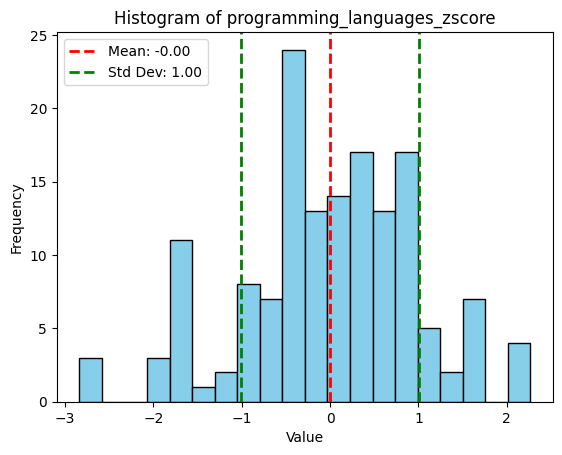

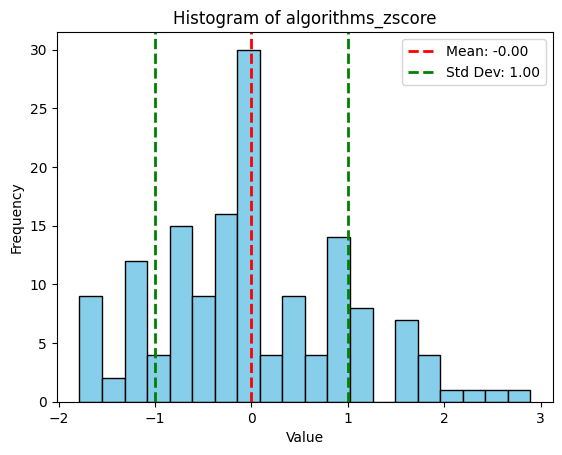

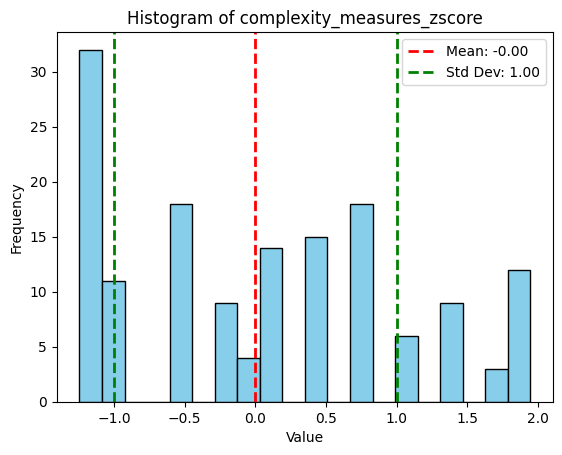

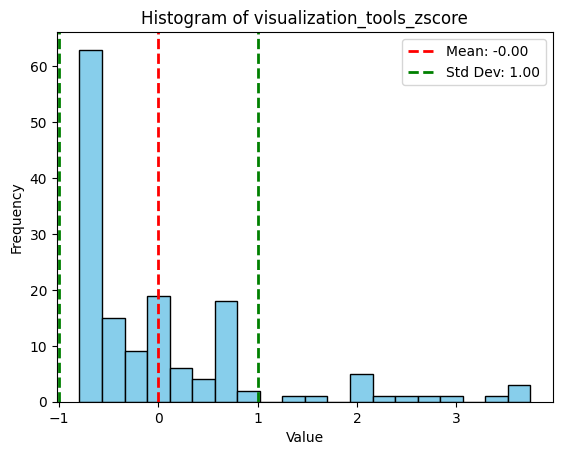

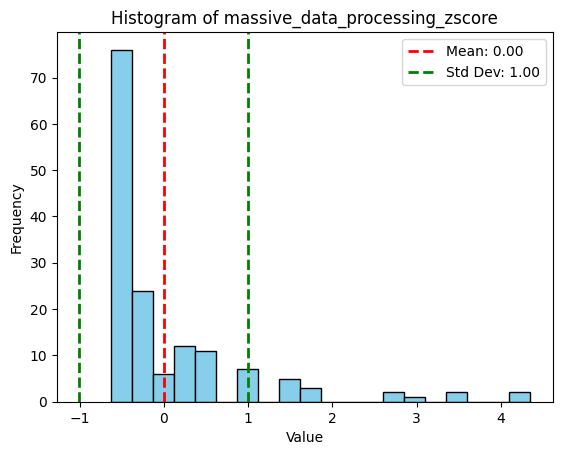

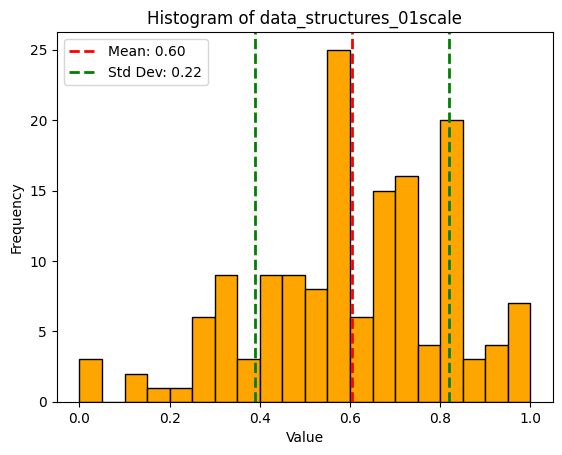

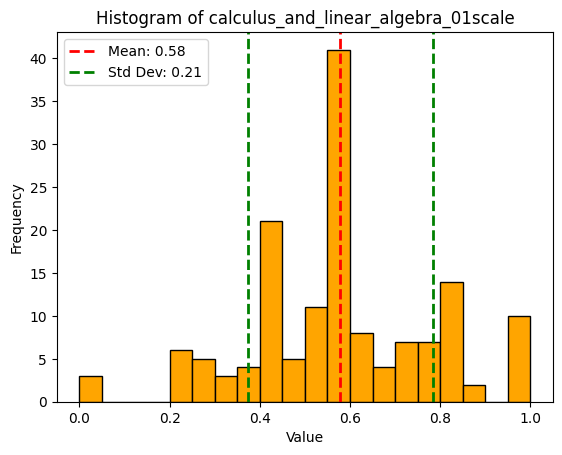

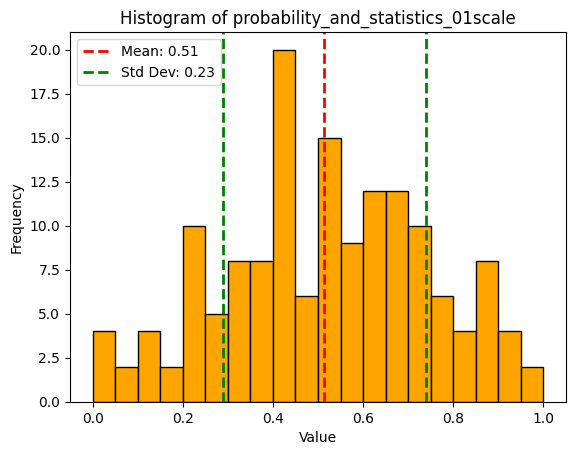

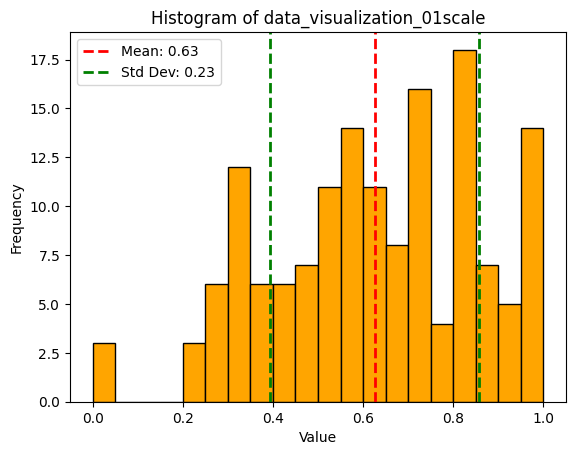

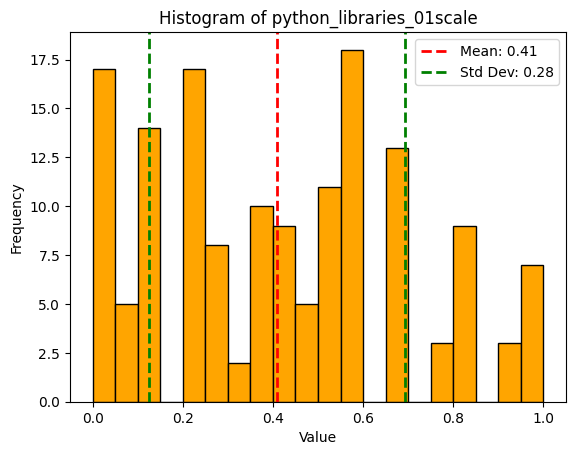

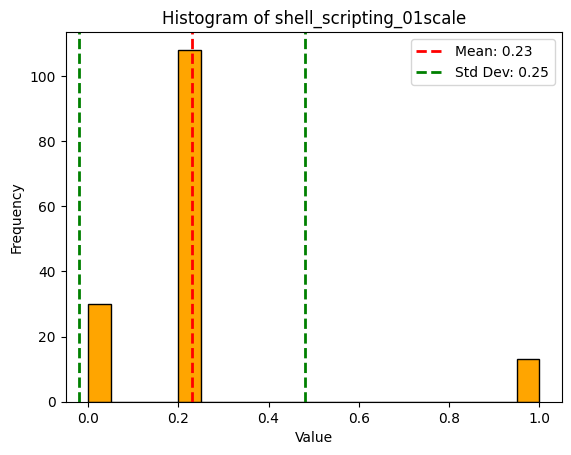

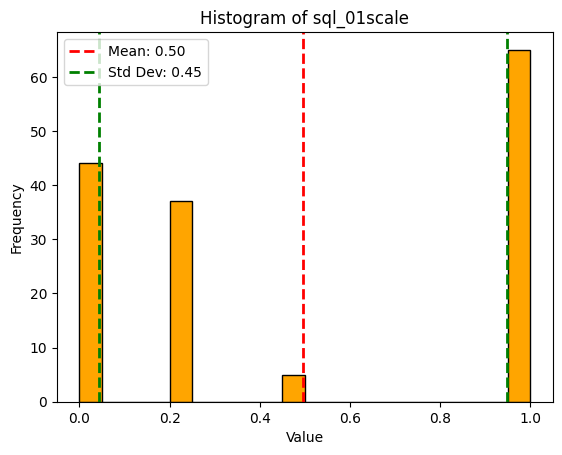

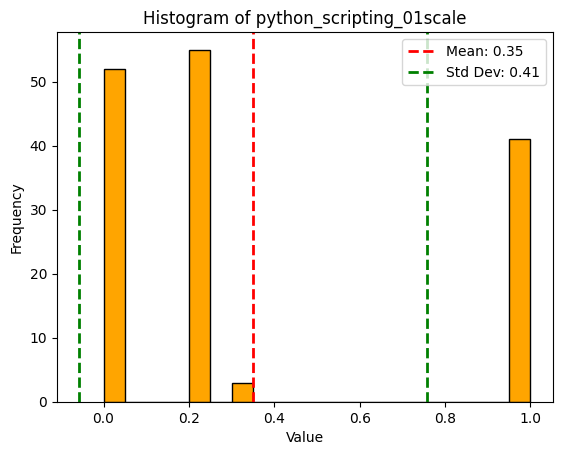

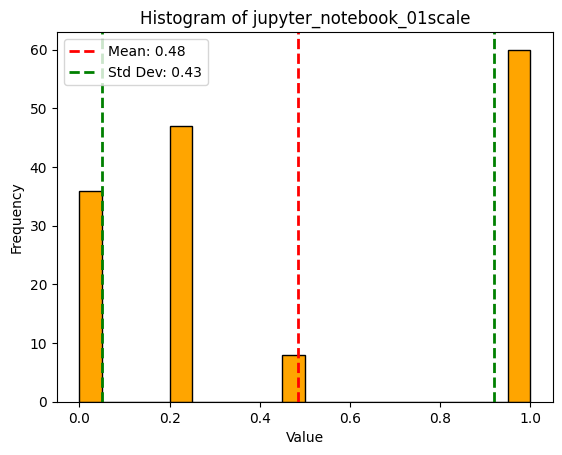

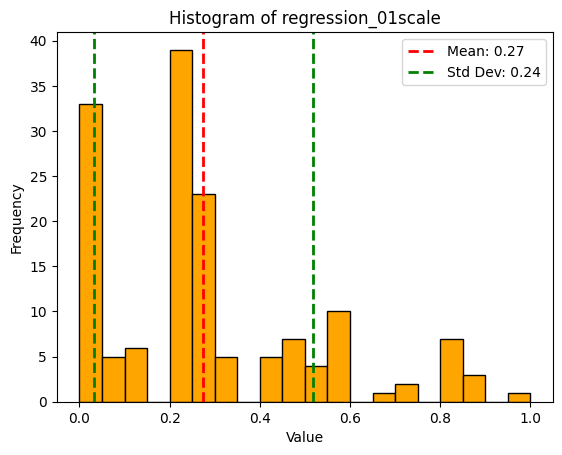

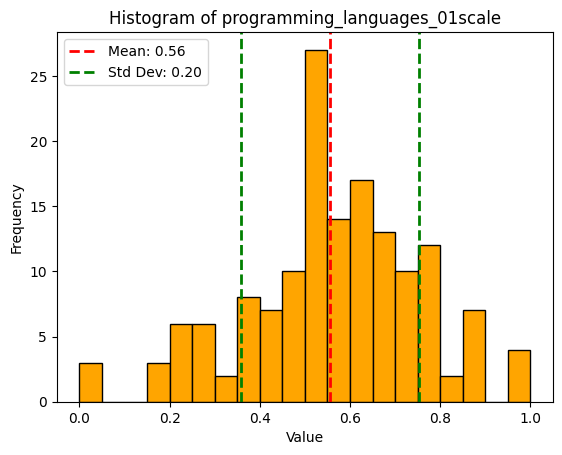

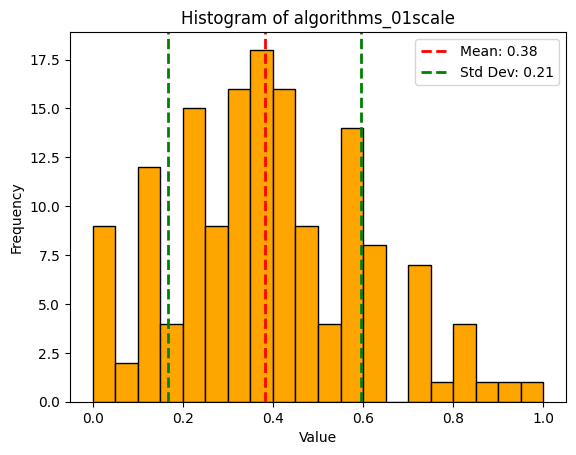

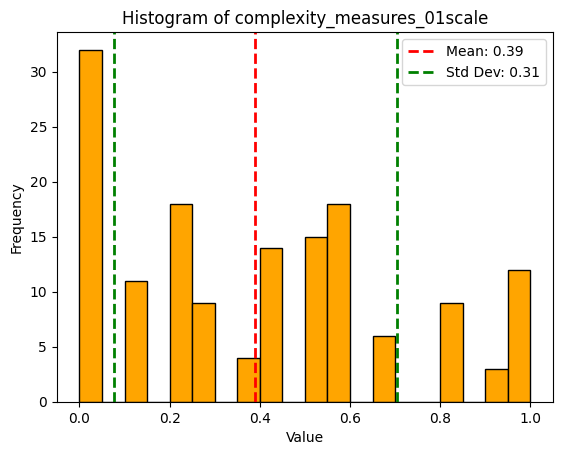

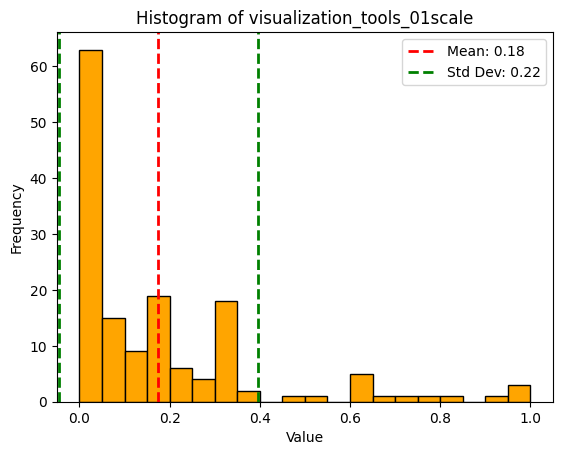

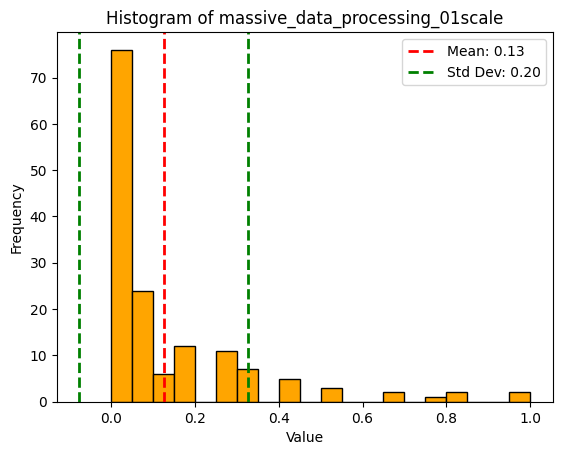

In [79]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    scale01_cols = [f'{c}_01scale' for c in skill_columns]
    mean_std = compute_mean_std(final_df, zscore_cols, scale01_cols)
    for col, stats in mean_std.items():
        print(f"{col}: Mean = {stats['mean']:.4f}, Std Dev = {stats['std']:.4f}")
    plot_skill_distributions(final_df, zscore_cols, scale01_cols, mean_std)

### 2. Define Distance Metric

Note: The returned distance matrix is expected to have a shape of `(len(df), len(df))`, where each entry `(i, j)` corresponds to the distance between `df.iloc[i]` and `df.iloc[j]`. Consequently, the diagonal entries `(i, i)` must be zero.

In [80]:
def calculate_distances(df, zscore_cols):
    """
    Calculates pairwise Euclidean distances.
    
    IN:
    df: pd.DataFrame, the dataframe with student data.
    zscore_cols: list of str, columns to use for distance calculation.
    
    OUT:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    """
    
    # convert df to matrix
    matrix = df[zscore_cols].to_numpy()

    # return square matrix of distances
    distances = squareform(pdist(matrix))


    return distances

Note: The condensed distance matrix is a flattened array that contains the upper triangular portion of the distance matrix, excluding the diagonal. Specifically, the first `len(df) - 1` entries represent the distances between the first data point and all subsequent points; the next `len(df) - 2` entries represent the distances between the second data point and all subsequent points, and so on.

**References:**
- [`scipy.spatial.distance.pdist` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)
- [`scipy.spatial.distance.squareform` Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)

In [81]:
def condense_distance_matrix(distances):
    """
    Condenses a square distance matrix into a condensed form.
    
    IN:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    
    OUT:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    """
    
    condensed_distances = squareform(distances)
    return condensed_distances

In [82]:
def squareform_distance_matrix(condensed_distances):
    """
    Converts a condensed distance matrix back to square form.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    
    OUT:
    distances: np.array of shape (len(df), len(df)), pairwise distances.
    """
    
    distances = squareform(condensed_distances)
    return distances

In [83]:

def normalize_distances(condensed_distances):
    """
    Applies z-score normalization to distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.

    OUT:
    condensed_distances_zscore: np.array of shape (len(df)*(len(df)-1)/2,), z-score normalized condensed pairwise distances.
    """
    
    # form [(value - mean) / std] for array

    mean = np.mean(condensed_distances)
    std = np.std(condensed_distances)

    condensed_distances_zscore = (condensed_distances - mean) / std

    return condensed_distances_zscore

Note: For all standard deviation calculations, use the population standard deviation, which corresponds to setting `ddof=0`.

In [84]:
def compute_dist_mean_std(condensed_distances):
    """
    Computes mean and standard deviation of the distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    
    OUT:
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    """
    
    mean = np.mean(condensed_distances)
    std = np.std(condensed_distances)
    
    return mean, std

In [85]:
def plot_distance_distribution(condensed_distances, mean, std, title='Distance Distribution'):
    """
    Plots the distribution of distances.
    
    IN:
    condensed_distances: np.array of shape (len(df)*(len(df)-1)/2,), condensed pairwise distances.
    mean: np.float64, mean of the distances.
    std: np.float64, standard deviation of the distances.
    title: str, the title of the plot.
    """
    plt.figure()
    plt.hist(condensed_distances, bins=20, color='skyblue', edgecolor='black')

    y_center = plt.ylim()[1] / 2

    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=2)

    plt.title(title)
    plt.xlabel('Pairwise Distances')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Original distances - Mean: 5.2492, Std Dev: 1.6265


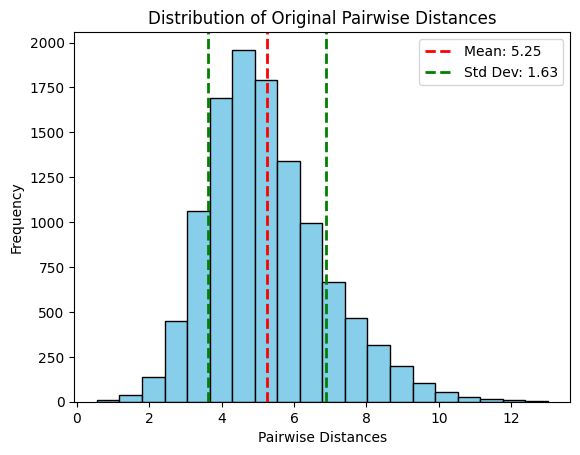

Normalized distances - Mean: 0.0000, Std Dev: 1.0000


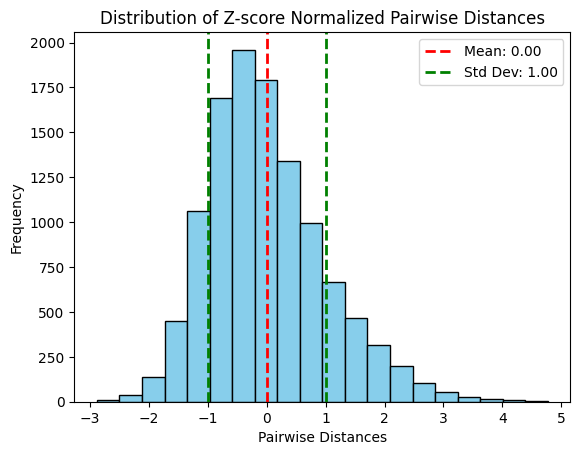

In [86]:
if __name__ == "__main__":
    zscore_cols = [f'{c}_zscore' for c in skill_columns]
    
    # Calculate and plot original distances
    distances = calculate_distances(final_df, zscore_cols)
    condense_distances = condense_distance_matrix(distances)
    mean, std = compute_dist_mean_std(condense_distances)
    print(f"Original distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(condense_distances, mean, std, 'Distribution of Original Pairwise Distances')

    # Normalize and plot z-score distances
    normalized_condensed_distances = normalize_distances(condense_distances)
    mean, std = compute_dist_mean_std(normalized_condensed_distances)
    print(f"Normalized distances - Mean: {mean:.4f}, Std Dev: {std:.4f}")
    plot_distance_distribution(normalized_condensed_distances, mean, std, 'Distribution of Z-score Normalized Pairwise Distances')

    # Convert back to square form
    normalized_distances = squareform_distance_matrix(normalized_condensed_distances)

### 3. Graph Construction Based on Distance Thresholds

In [87]:
def construct_graph(df, distance_matrix, threshold, name):
    """
    Constructs a graph based on a distance threshold.
    
    IN:
    df: pd.DataFrame, dataframe with node information.
    distance_matrix: np.array, 
    threshold: float, the distance threshold for creating edges.
    name: str, the name of the graph.
    
    OUT:
    G: nx.Graph, the constructed graph.
    """
    G = nx.Graph(name=name)
    
    # Add nodes with attributes
    for idx, row in df.iterrows():
        G.add_node(row['netid'],
               total_score=row['total_score'],
               role=row['role'],
               major=row['major'])
        
    # Add edges based on the threshold
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if distance_matrix[i, j] < threshold:
                netid_i = df.iloc[i]['netid']
                netid_j = df.iloc[j]['netid']
                G.add_edge(netid_i, netid_j, weight=distance_matrix[i, j])
                
    return G

In [88]:
if __name__ == "__main__":
    # The mean of z-score normalized distances is approximately 0, and the standard deviation is 1.
    # Thresholds are defined in terms of standard deviations below the mean.
    thresholds = {
        -3: -3,  # 3 SD below the mean
        -2: -2,  # 2 SD below the mean
        -1: -1   # 1 SD below the mean
    }
    
    graphs = {}
    for sd, thresh_val in thresholds.items():
        graph_name = f"Student_Assessment_Graph_{sd}SD"
        # The z-score normalized distance matrix is used for graph construction.
        graphs[graph_name] = construct_graph(final_df, normalized_distances, thresh_val, graph_name)
        print(f"Graph '{graph_name}' constructed with threshold {thresh_val}.")
        print(f"  - Nodes: {graphs[graph_name].number_of_nodes()}")
        print(f"  - Edges: {graphs[graph_name].number_of_edges()}")

Graph 'Student_Assessment_Graph_-3SD' constructed with threshold -3.
  - Nodes: 151
  - Edges: 0
Graph 'Student_Assessment_Graph_-2SD' constructed with threshold -2.
  - Nodes: 151
  - Edges: 72
Graph 'Student_Assessment_Graph_-1SD' constructed with threshold -1.
  - Nodes: 151
  - Edges: 1578


### 4. Graph Analysis

Note: break tie for nodes of the same degree by their `netid` alphabetically in non-decreasing order.

In [ ]:
def analyze_graph(G, df):
    """
    Performs analysis for a given graph.
    
    IN:
    G: nx.Graph, the graph to analyze.
    df: pd.DataFrame, dataframe with node attributes.
    
    OUT:
    analysis_results: dict,
        {"num_nodes": int,
         "num_edges": int,
         "avg_degree": float,
         "degrees": list of int,
         "top_10_nodes": list of [str, int] as [netid, degree],
         "num_components": int,
         "comp_sizes": list of ints as [vSize, eSize]
         }
    """
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)

    degrees = [val for (node, val) in G.degree()]
    avg_degree = np.mean(degrees) if degrees else 0

    comp_sizes = [(len(c), G.subgraph(c).number_of_edges()) for c in nx.connected_components(G)]

    degree_df = pd.DataFrame({'netid': G.nodes(), 'degree': degrees})
    degree_df = degree_df.sort_values(by='degree', ascending=False)

    if not degree_df.empty:
        top_10_percentile_degree = degree_df['degree'].quantile(0.9)
        top_10_nodes = degree_df[degree_df['degree'] >= top_10_percentile_degree][['netid', 'degree']].values.tolist()

        
    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "degrees": degrees,
        "top_10_nodes": top_10_nodes,
        "num_components": num_components,
        "comp_sizes": comp_sizes
    }


# test
# G_test = nx.Graph(name="TestGraph")
# G_test.add_nodes_from(["A", "B", "C", "D", "E"])
# G_test.add_edges_from([("A","B"), ("B","C"), ("D","E")])


# analysis = analyze_graph(G_test, df=None)  # df is not used for degree/top10
# print(analysis)

{'num_nodes': 5, 'num_edges': 3, 'avg_degree': np.float64(1.2), 'degrees': [1, 2, 1, 1, 1], 'top_10_nodes': [['B', 2]], 'num_components': 2, 'comp_sizes': [(3, 2), (2, 1)]}


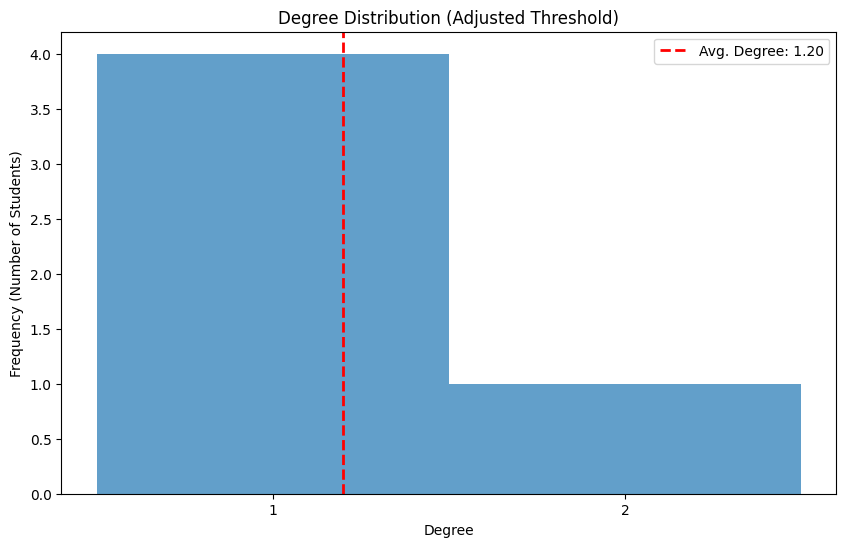

In [ ]:
def plot_degree_distribution(G, analysis_results):
    """
    Visualizes the analysis results of a graph.
    
    IN:
    G: nx.Graph, the graph to visualize.
    analysis_results: dict, the analysis results from analyze_graph.
    """

    avg_degree = analysis_results['avg_degree']
    degrees = analysis_results['degrees']
    top_10_nodes = analysis_results['top_10_nodes']


    # Degree distribution
    plt.figure(figsize=(10, 6))
    if degrees:
        bins = range(min(degrees), max(degrees) + 2)
        plt.hist(degrees, bins=bins, alpha=0.7, align='left')
        plt.xticks(range(min(degrees), max(degrees) + 1))
    else:
        plt.hist([0], bins=1, alpha=0.7, align='left')

    plt.axvline(avg_degree, color='red', linestyle='dashed', linewidth=2, label=f'Avg. Degree: {avg_degree:.2f}')
    plt.title('Degree Distribution (Adjusted Threshold)')
    plt.xlabel('Degree')
    plt.ylabel('Frequency (Number of Students)')
    plt.legend()
    plt.show()

# test
# plot_degree_distribution(G_test, analysis)


In [91]:
def compute_cc_size_frequency(comp_sizes):
    """
    Computes the frequency of connected component sizes.
    
    IN:
    comp_sizes: list of tuples (vSize, eSize) for each connected component.
    
    OUT:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """
    comp_size_freq = dict(Counter(comp_sizes))

    return comp_size_freq

In [ ]:
def plot_cc_size_distribution(comp_size_freq):
    """
    Plots the connected component size distribution.
    
    IN:
    comp_size_freq: dict {(vSize, eSize): frequency}
    """

    if not comp_size_freq:
        print("No connected components to plot.")
        return

    # sort by vertex size, then edge size
    items = sorted(comp_size_freq.items(), key=lambda x: (x[0][0], x[0][1]))
    labels = [f"v:{v}, e:{e}" for (v, e), _ in items]
    freqs = [freq for _, freq in items]

    plt.figure(figsize=(10,6))
    plt.bar(labels, freqs, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Connected Component Size (vertices, edges)")
    plt.ylabel("Frequency")
    plt.title("Connected Component Size Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


In [101]:
def plot_graph_layout(G):
    """
    Plots the force-directed layout of the graph.

    IN:
    G: nx.Graph, the graph to visualize.
    """
    # Create fig and ax objects explicitly to avoid colorbar errors
    fig, ax = plt.subplots(figsize=(20, 20))

    # Generate layout
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

    # Get node colors based on 'total_score'
    node_scores = [G.nodes[node]['total_score'] for node in G.nodes()]
    if node_scores:
        norm = mcolors.Normalize(vmin=min(node_scores), vmax=max(node_scores))
    else:
        norm = mcolors.Normalize(vmin=0, vmax=1)

    cmap = plt.get_cmap(COLORMAP)
    node_colors = [cmap(norm(score)) for score in node_scores]

    # Draw the graph on the specified axes
    nx.draw_networkx(
        G,
        pos,
        ax=ax,
        with_labels=False,
        node_size=60,
        node_color=node_colors,
        width=0.3
    )

    # Add colorbar linked to the axes
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Total Score (Sum of Z-Scores)')

    ax.set_title(f'Student Similarity Graph', fontsize=20)
    ax.axis('off')

    plt.show()

Note: the expected output format for saving the graphs in JSON is as follows:

```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23},
    { "id": "node2", "total_score": 2.34},
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

In [102]:
def save_graph_to_json(G):
    """
    Saves the graph to a JSON file in node-link format.
    
    IN:
    G: nx.Graph, the graph to save.
    """
    
    # Save graph to JSON format
    graph_data = nx.node_link_data(G, nodes="nodes", edges="links")
    json_filename = f"{G.name}.json"
    with open(json_filename, 'w') as f:
        json.dump(graph_data, f, indent=4)
    print(f"Graph saved to {json_filename}")


--- Analysis for Student_Assessment_Graph_-3SD ---

Top 10% (151 students) by degree:
            netid  total_score
90       c1d4dedb     0.861557
31   fce8fefdf5a0   -13.913913
102  8a90d1898fdf     2.451389
156  d6da8cd2d28d   -15.052428
22   d3ca9bdadc85    -4.258010
..            ...          ...
128  6e7832636338    -6.990046
15     697760696d    -7.091736
33     534b5f535e    -6.342962
17     c1c7c4cbc8   -12.621991
10   54490a53500a    24.514467

[151 rows x 2 columns]


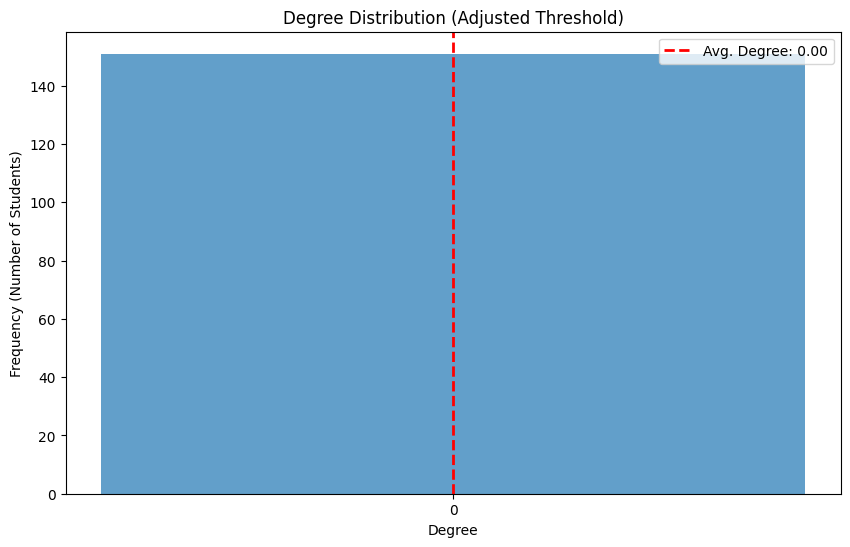

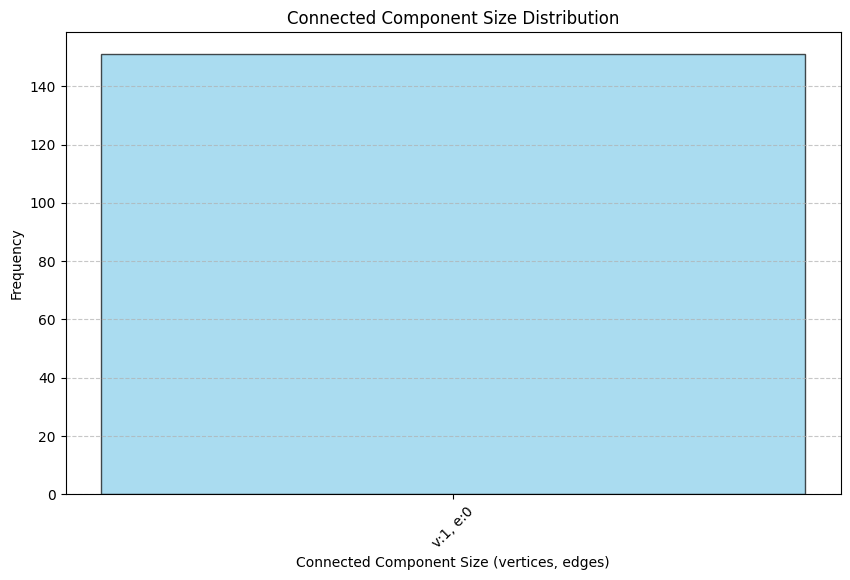

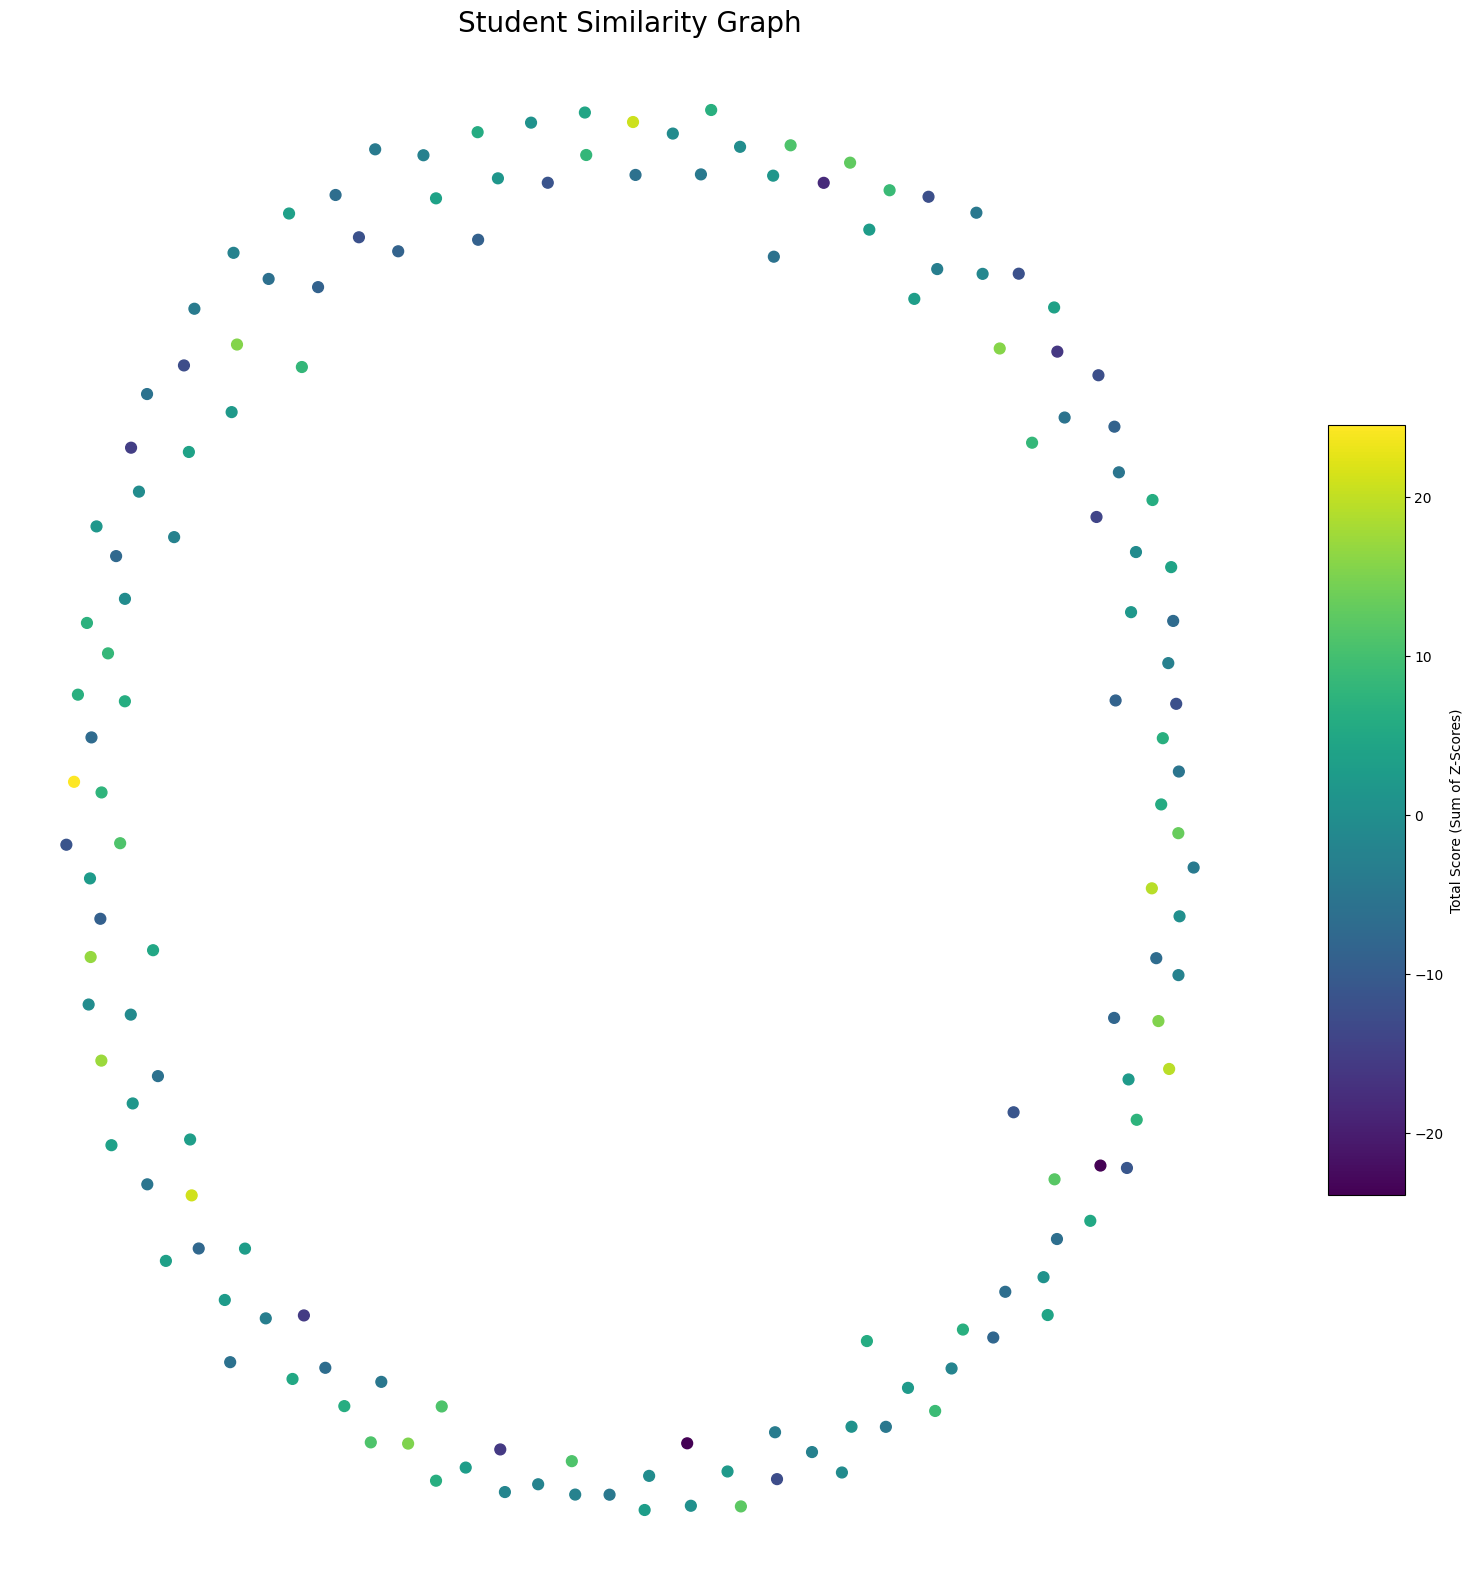

Graph saved to Student_Assessment_Graph_-3SD.json

--- Analysis for Student_Assessment_Graph_-2SD ---

Top 10% (18 students) by degree:
              netid  total_score
31     fce8fefdf5a0   -13.913913
156    d6da8cd2d28d   -15.052428
86     47545e565704    -5.024696
136    b9adb8bcbbe4   -11.424257
41     464a4347411c   -15.899809
51     0d367927237d    -8.743185
135  d6cf94d6d68e9b   -11.978493
2      5d504543461b    -0.681787
30       c0d6cbcec4   -16.156869
140    4a4f00414012    -2.834475
94       6c68707077   -11.235986
151        0c014b13   -12.308536
11       1d38202e27    -4.578902
12         5c7e2c66    -5.141247
26     f0c08cd0d58b   -15.471553
131      4743505959   -12.195626
45       9a899f989a    -5.679096
17       c1c7c4cbc8   -12.621991


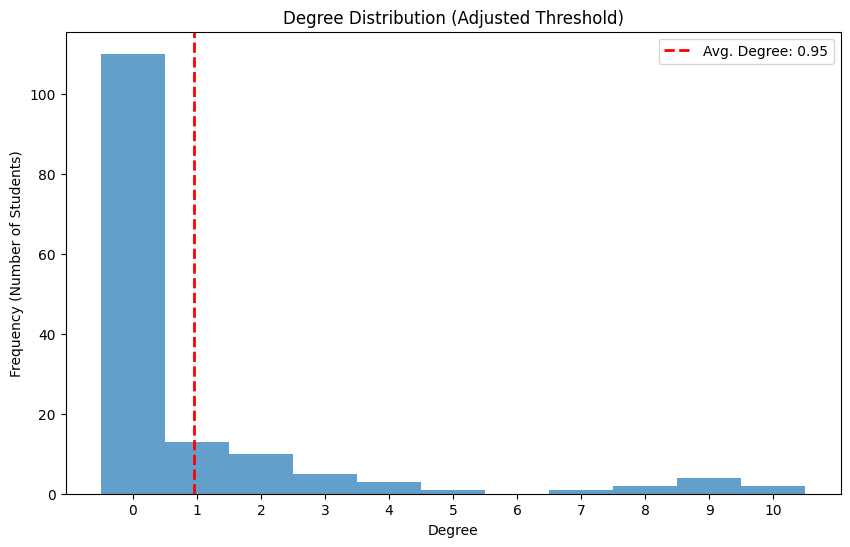

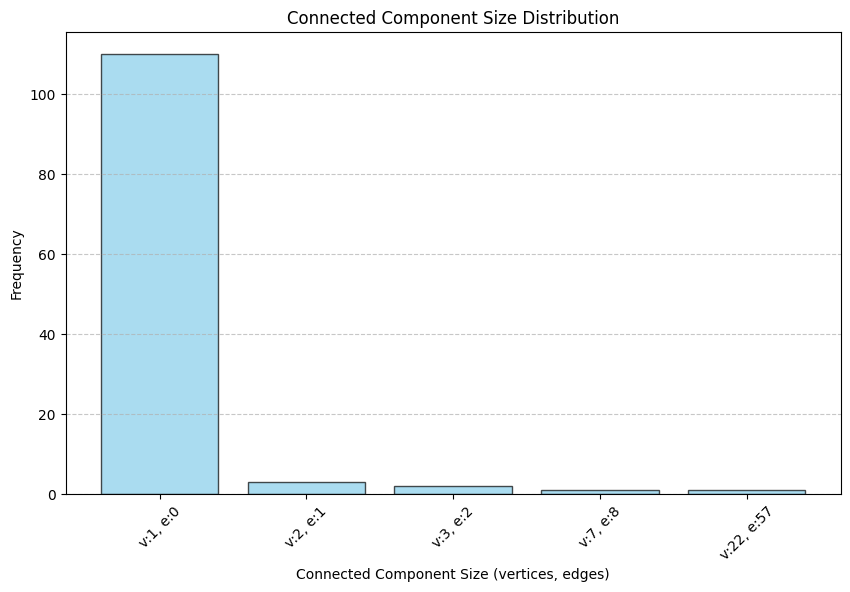

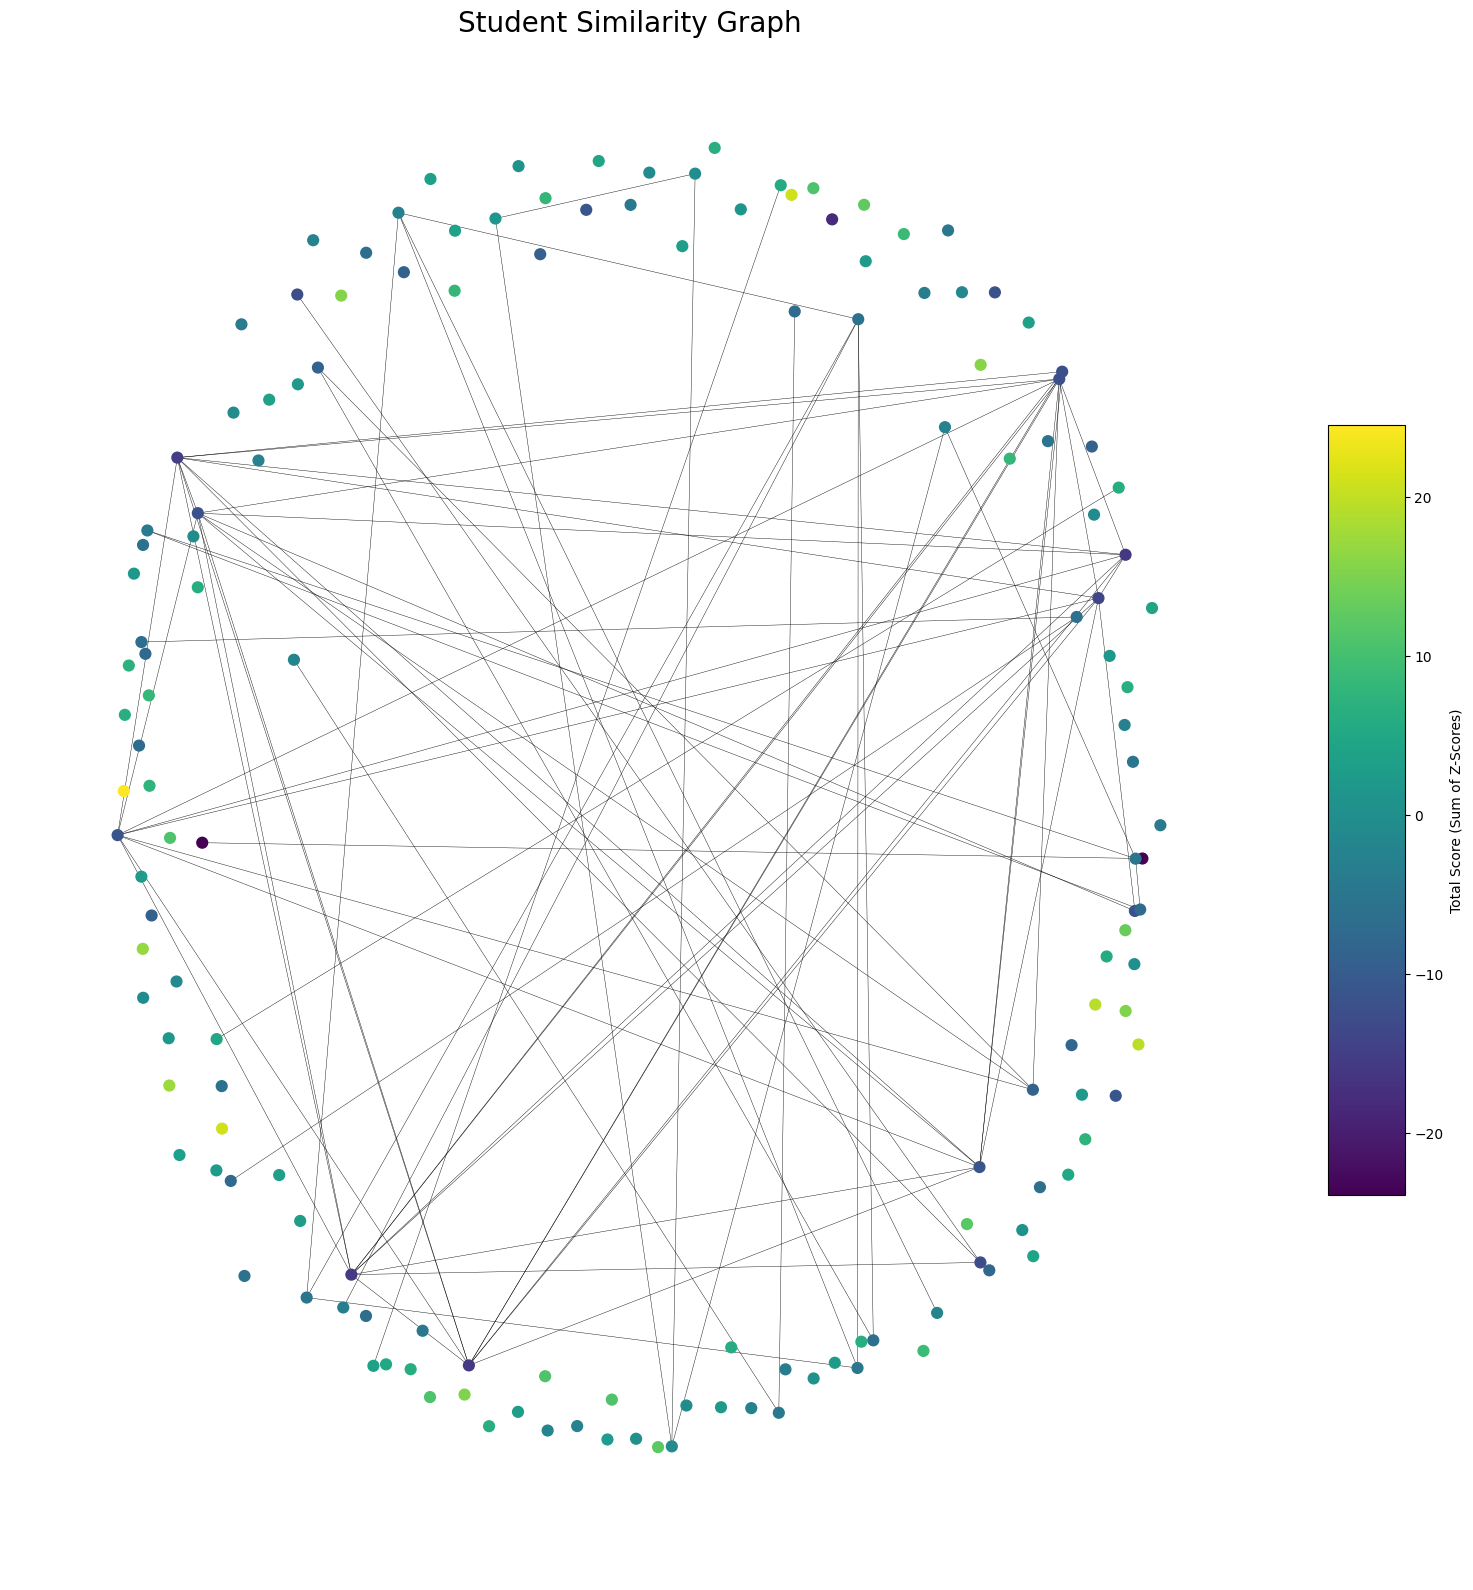

Graph saved to Student_Assessment_Graph_-2SD.json

--- Analysis for Student_Assessment_Graph_-1SD ---

Top 10% (17 students) by degree:
              netid  total_score
149    383e22212178    -4.068361
61       8d9085848c    -0.771492
6        c4c796d4d7    -0.995057
136    b9adb8bcbbe4   -11.424257
51     0d367927237d    -8.743185
135  d6cf94d6d68e9b   -11.978493
139    3a2d3138356e    -8.761186
98       373e6a3439    -3.819645
44       c5c99ed8de    -4.586530
140    4a4f00414012    -2.834475
74     dec2dadedf87    -5.958399
121    716573707023    -6.674910
40       717b747272    -7.112904
11       1d38202e27    -4.578902
12         5c7e2c66    -5.141247
45       9a899f989a    -5.679096
120    2f2363343e6e    -9.005038


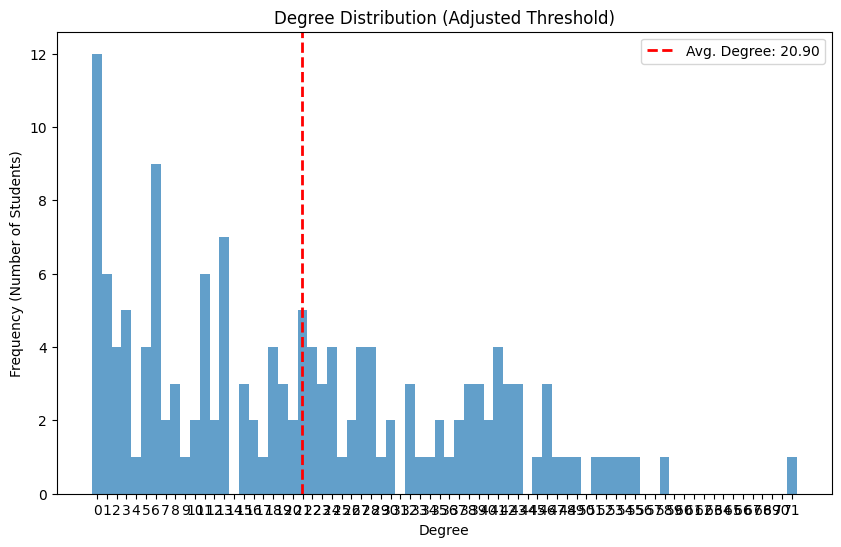

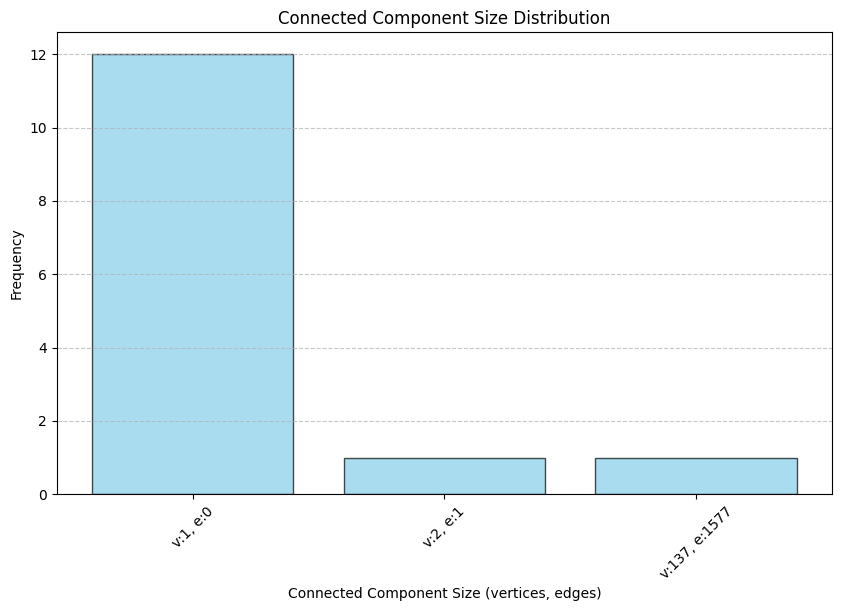

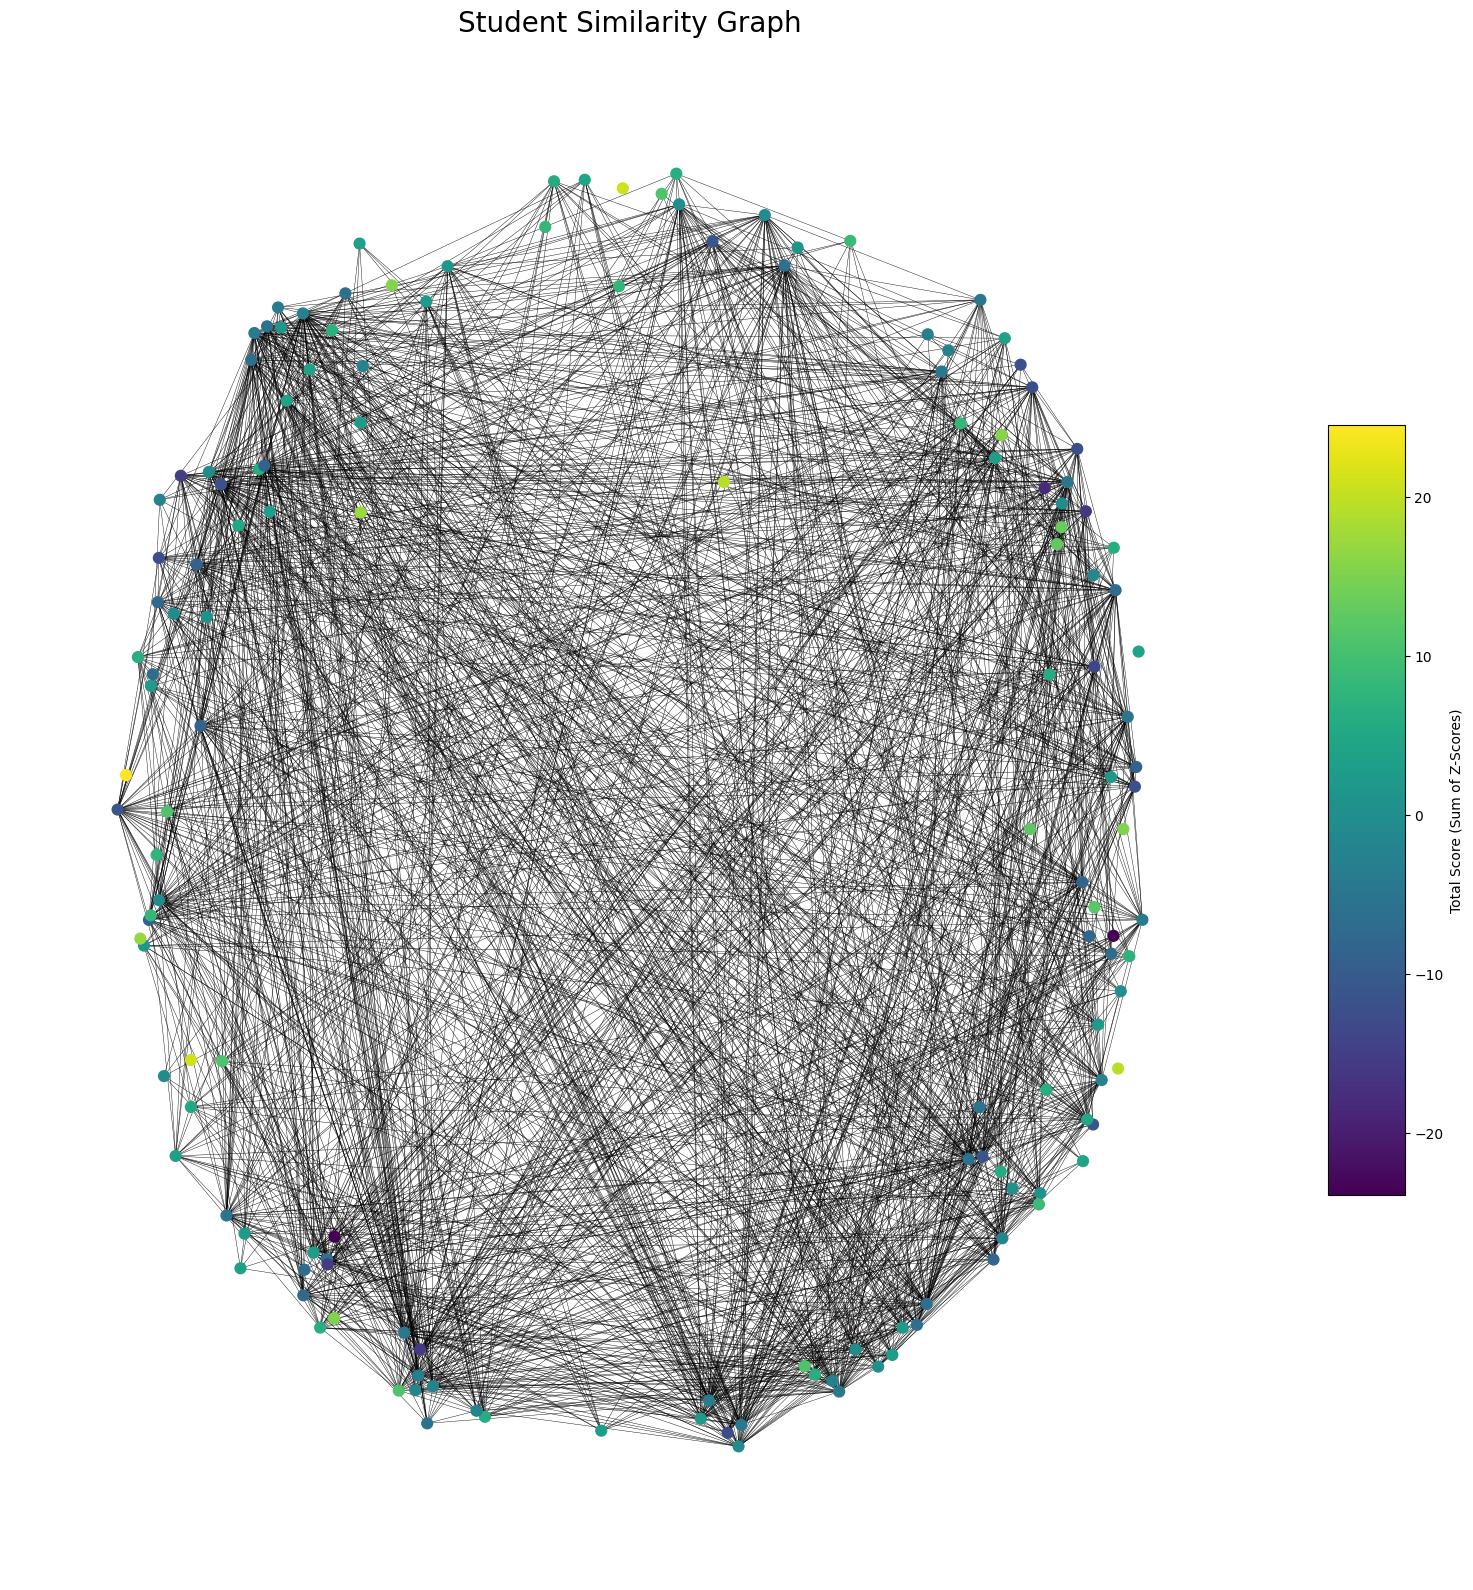

Graph saved to Student_Assessment_Graph_-1SD.json


In [103]:
if __name__ == "__main__":
    for name, graph in graphs.items():
        print(f"\n--- Analysis for {name} ---")
        analysis_results = analyze_graph(graph, final_df)
        top_10_netids = [netid for netid, _ in analysis_results['top_10_nodes']]
        top_10_info = final_df[final_df['netid'].isin(top_10_netids)][['netid', 'total_score']]
        print(f"\nTop 10% ({len(top_10_info)} students) by degree:")
        print(top_10_info)

        plot_degree_distribution(graph, analysis_results)

        comp_size_freq = compute_cc_size_frequency(analysis_results['comp_sizes'])
        plot_cc_size_distribution(comp_size_freq)


        plot_graph_layout(graph)
        
        save_graph_to_json(graph)

After exporting each graph to JSON, the files may be visualized interactively using `2D-vis.html` or `3D-vis.html`.

To encode vertex colors according to the `total_score` attribute, include a `color` property for each node in the JSON representation.

Suggested procedure:
1. Map the `total_score` values to an appropriate color scale (for example, a sequential or diverging colormap).
2. Convert the mapped color values to a hexadecimal RGB string (for example `#66ccff`).
3. Assign the resulting hex string to the node's `color` property, e.g. `node["color"] = "#66ccff"`.

An example of the expected JSON structure is shown below:
```json
{
  "nodes": [
    { "id": "node1", "total_score": 1.23, "color": "#66ccff" },
    { "id": "node2", "total_score": 2.34, "color": "#ff0000" },
    ...
  ],
  "links": [
    { "source": "node1", "target": "node2" },
    ...
  ]
}
```

When such a JSON file is loaded into `2D-vis.html` or `3D-vis.html`, the renderer will apply the specified `color` values to the vertices, producing a visualization in which node colors reflect their `total_score`.